In [1]:
# f = (f' - B - d * t) / med (f' - b - d * t)
# D = D' - B
# B = B' + Berr

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
# parameters
# gain electrons per adu
g = 3.6
# dimension 
row = 2048
column = 2048
# bias levels 
# real bias level count per pixel 
bias_real_level = 300
# the systematic readout error on the bias
readnoise = 5
# assumed bias level 
# float up to factor 
factor = 2 
bias_meas_array = np.linspace(bias_real_level/factor, bias_real_level*factor)
# bias_meas_array = [bias_real_level]
# dark
# dark current elec per sec
d = 0.05
# time dark exposure
td = 60
# flat counts per pixel 
f = 10000
# time flat exposure 
tf_array = np.linspace(3, 120)

In [4]:
para_dict = {
    'bias_level': 300,
    'row': 2048,
    'column': 2048,
    'g': 3.6,
    'readnoise': 5,
    'd': 0.05,
    'td': 60,
    'f': 10000,
    'tf_array': np.linspace(3, 120)   
}

In [5]:
# function making a bias based on a given bias input
# normal distributed 
# output: 2d bias level in counts per pixel 
def makeBias(bias_level,size=(row,column),readnoise=5,debug=False):
    bias = np.random.normal(bias_level, readnoise, size)
    return bias

In [6]:
def makeDarkCounts(td=60,d=0.05,size=(row,column),debug=False,g=3.6):
    dark_counts = np.random.poisson(d*td, size) / g 
    return dark_counts

In [7]:
# dark function based on a given bias input
# possion distributed
# output: 2d dark current in counts per sec per pixel 
def makeDark(bias_level,td=60,d=0.05,size=(row,column),debug=False,g=3.6):
    dark = makeDarkCounts(td=td,d=d,size=size,debug=debug,g=g) + \
                              makeBias(bias_level,size=size,debug=debug)
    return dark    

In [8]:
# flat function 
# possion distributed 
# output: 2d raw flat level in counts per pixel 
def makeRawFlat(bias_level,debug=False,g=3.6,
                f=15000,size=(row,column)):
    flat = makeBias(bias_level) + np.random.poisson(f, size)
    return flat

In [9]:
# calibrated flat function 
# output: 2d calibrated flat level in counts per pixel 
def makeCaliFlat(bias, dark, raw_flat, tf=3, td=60, debug = False):
    caliFlat = (raw_flat - dark / td * tf - bias) / np.median(raw_flat - dark * tf - bias)
    return caliFlat 

In [10]:
def systematic_deviation(bias_level, time = 1, tf_array = tf_array, debug = False):
    # see the error with same bias 
    percent_change_in_flat_array = []
    percent_change_in_flat_array_std = []
    tf_plot_array = []
    for tf in tf_array:
        percent_change_in_flat_array_storage = []
        for i in range(time):
            bias_real_1 = makeBias(bias_level)
            dark_real_1 = makeDark(bias_level)
            flat_raw_1 = makeRawFlat(bias_level, tf)
            flat_real_1 = makeCaliFlat(bias_real_1, dark_real_1, flat_raw_1, tf)
            bias_real = makeBias(bias_level)
            dark_real = makeDark(bias_level)
            flat_raw = makeRawFlat(bias_level, tf)
            flat_real = makeCaliFlat(bias_real, dark_real, flat_raw, tf)
            deltaf = np.abs(flat_real - flat_real_1)
            # flat percent change in a mean form 
            percent_change_in_flat = np.mean(deltaf / flat_real_1 * 100)
            percent_change_in_flat_array_storage.append(percent_change_in_flat)
        mean = np.mean(percent_change_in_flat_array_storage)
        std = np.std(percent_change_in_flat_array_storage)
        percent_change_in_flat_array.append(mean)
        percent_change_in_flat_array_std.append(std)
        tf_plot_array.append(tf)
    plt.scatter(tf_plot_array, percent_change_in_flat_array)
    plt.errorbar(tf_plot_array, percent_change_in_flat_array,
                yerr = percent_change_in_flat_array_std,
                fmt ='o')
    plt.xlabel('TF changes')
    plt.ylabel('Flat changes perc')
    plt.show()
    

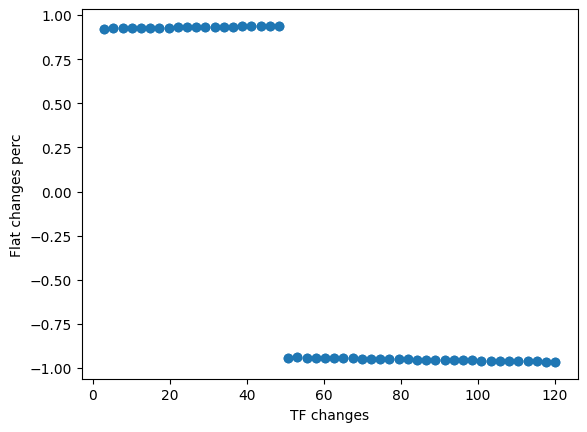

In [11]:
systematic_deviation(bias_real_level)

In [ ]:
def func(xy, a, b, c, d, e, f):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x*y

In [229]:
def propagation(bias_real_level = bias_real_level, bias_meas_array = bias_meas_array, tf_array = tf_array, debug = False):
    # prop storage array
    percent_change_in_bias_array = []
    percent_change_in_flat_array = []
    tf_plot_array = []

    # making the real bias, dark, and flat
    bias_real = makeBias(bias_real_level)
    dark_real = makeDark(bias_real_level)
    flat_raw_dict = {}
    flat_real_dict = {}
    for tf in tf_array:
        flat_raw = makeRawFlat(bias_real_level, tf)
        flat_real = makeCaliFlat(bias_real, dark_real, flat_raw, tf)
        flat_real_dict[tf] = flat_real
        
    # prop 
    for b in bias_meas_array:
        # measured bias 2d array
        bias_meas = makeBias(b)
        # bias displacement
        deltab = bias_real - bias_meas
        # bias percent change mean
        percent_change_in_bias = np.mean(deltab / bias_real * 100)
        # measured dark 
        dark_meas = makeDark(b)
        for tf in tf_array:
            # real calibrated flat in a 2d array 
            flat_real = flat_real_dict[tf]
            # measured raw flat in a 2d array
            flat_raw = makeRawFlat(b)
            # measured flat in a 2d array
            flat_meas = makeCaliFlat(bias_meas, dark_meas, flat_raw, tf)
            # flat displacement in a 2d 
            deltaf = np.abs(flat_real - flat_meas)
            # flat percent change in a mean form 
            percent_change_in_flat = np.mean(deltaf / flat_real * 100)
            percent_change_in_bias_array.append(percent_change_in_bias)
            percent_change_in_flat_array.append(percent_change_in_flat)
            tf_plot_array.append(tf)
    
    # Perform curve fitting
    popt, pcov = curve_fit(func, (percent_change_in_bias_array, tf_plot_array), percent_change_in_flat_array)
    
    if debug: 
            
        X, Y = np.meshgrid(percent_change_in_bias_array, tf_plot_array)
        pred_flat_change = func((X, Y), *popt)
        
        ax = plt.axes(projection='3d')
        # Adding data to our axes, 's=40' is to increase point size by 40
        ax.scatter3D(percent_change_in_bias_array, tf_plot_array, percent_change_in_flat_array, s=1) 
        ax.plot_surface(X, Y, pred_flat_change, color='red', alpha=0.5)
        # Labelling your axes
        ax.set_xlabel('Percent change in Bias')
        ax.set_ylabel('Time Flat Exposure')
        ax.set_zlabel('Percent change in Flat')
        ax.view_init(0, 45)
        
    return popt, pcov
            
    

In [ ]:
# # prop
# for b in bias_meas_mean:
#     # bias measured in a 2d form with systematic error
#     bias_meas = np.array([[np.random.normal(b, bias_err) for _ in range(column)] for _ in range(row)])
#     # bias displacement in a 2d form 
#     deltab = bias_real - bias_meas
#     # bias change in a mean form
#     percent_change_in_bias = np.mean(deltab / bias_real * 100)
#     # measured dark 
#     d_meas = d / g - bias_meas / td
#     # for each flat exposure time 
#     for tf in tf_array:
#         # real flat in a 2d array form 
#         flat_real = (flat_raw - d_real * tf - bias_real) / np.median(flat_raw - d_real * tf - bias_real)
#         # flat measured in a 2d array form
#         flat_meas = (flat_raw - d_meas * tf - bias_meas) / np.median(flat_raw - d_meas * tf - bias_meas)
#         # flat displacement in a 2d 
#         deltaf = flat_real - flat_meas
#         # flat percent change in a mean form 
#         percent_change_in_flat = np.mean(deltaf / flat_meas * 100)
#         percent_change_in_bias_array.append(percent_change_in_bias)
#         percent_change_in_flat_array.append(percent_change_in_flat)
#         tf_plot_array.append(tf)

In [ ]:
# # number of pixels in rows and columns, can change with the dimension of the CCD
# rows = 100
# columns = 100
# # dark counts per second per pixel 
# dark = 2 
# # the flactuation of flat with a 3% error
# flatUpper = 1.03
# flatLower = 0.97
# # bias counts and overall bias level change
# bias = 4000
# biasChangeUpper = 0.2
# biasChangeLower = 0.01
# # integration time 
# time = 300 

# # flat field randomization
# flatField = np.matrix([[np.random.uniform(flatLower, flatUpper) for _ in range(columns)] for _ in range(rows)])

In [ ]:
# #change for the bias
# biasChange = np.linspace(biasChangeLower, biasChangeUpper)
# # flat field propagation 
# mean_displacement = []
# for b in biasChange:  
#     master_bias = np.matrix([[np.random.normal(bias, bias * b) for _ in range(columns)] for _ in range(rows)])
#     master_dark = dark * time + master_bias
#     flat = flatField - master_dark - master_bias
#     flat /= np.mean(flat)
#     displacement = np.mean(np.abs((flat - flatField)) / flatField)
#     mean_displacement.append(displacement) 
    
# plt.plot(biasChange, mean_displacement, 'o')
# plt.title("BiasPropagation")
# plt.xlabel('BiasChange')
# plt.ylabel('Displacement')
# plt.show()

In [ ]:
# fit = np.polyfit(biasChange, mean_displacement,1,full=False, cov=True)

# # Fit parameters are the first element in the returned "tuple"
# fitparams = fit[0]
# slope = fitparams[0]
# intercept = fitparams[1]

# # Covariance matrix is the second element in the returned "tuple"
# cov = fit[1]

# # This is the way you get errors out of the covariance matrix.
# param_error = np.sqrt(np.diagonal(cov))
# slope_error = param_error[0]
# intercept_error = param_error[1]

# slope_output = 'slope is %.3f +/- %0.3f' %(slope,slope_error)
# intercept_output = 'intercept is %.3f +/- %0.3f' %(intercept,intercept_error)

# plt.errorbar(biasChange,mean_displacement)
# plt.xlabel('Bias')
# plt.ylabel('Mean Displacement (flat - flatPrime) / flatPrime')
# xfit = np.linspace(plt.xlim()[0],plt.xlim()[1],100)
# yfit = intercept + slope*xfit
# plt.plot(xfit,yfit,'r--', label='Linear output with ' + slope_output + intercept_output)
# plt.legend()

# print('The slope is %.3f +/- %0.3f' %(slope,slope_error))
# print('The intercept is %.3f +/- %0.3f' %(intercept,intercept_error))
# # plt.savefig('Updated Linear model')